## Verstehen von Q_n, Q_p und Q_Li als Inputs für die Bestimmung von den minimalen und maximalen stöchiometrischen Grenzen
Die Domänengröße `Q` hängt direkt mit der zyklierbarem Lithium-Ionen in dem Modell zusammen und dient als Grundlage zur Festlegung der maximalen und minimalen Stöchiometrien in den Elektroden.

---
### Fehlerbild aus "C_rate_experiment (24.01.2023)" - Auszug
Derzeit (24.01.2023) funktioniert der Prozess zum Setzen des anfänglichen Ladezustands nicht. Der Fehler deutet daraufhin, dass das die Bestimmung der maximalen und minimalen Stöchiometrien für die Zelle nicht funktionieren.

* pybamm.Simulation(kwargs).solve(initial_soc=soc_ini) - soc_ini = [0,1]
    * pybamm.simulation.set_initial_soc
        * pybamm.parameter_values.set_initial_stoichiometries
            * pybamm.lithium_ion.get_initial_stoichiometries -> esoh_solver.get_initial_stoichiometries
                * esoh_solver.get_min_max_stoichiometries
                    * <span style="color:red">**Was ist Q???**</span>.
---


### Berechnung von Q in PyBaMM
Q beschreibt die Ladungsmenge in der einzelnen Domäne durch die Anzahl der Lihtium-Ionen in der Domäne

Die Berechnung von Q erfolgt insgesamt für die Zelle (oder ist hier der Elektrolyt gemeint?) und für die einzelnen Aktivmaterialien.

in `pybamm.lihtium_ion_parameters` Zeile 138f für "Total Lithium":
    
    self.n_Li_particles_init = self.n.n_Li_init + self.p.n_Li_init
    self.n_Li_init = self.n_Li_particles_init + self.n_Li_e_init
    self.Q_Li_particles_init = self.n_Li_particles_init * self.F / 3600
    self.Q_Li_init = self.n_Li_init * self.F / 3600 

in `pybamm.lihtium_ion_parameters` Zeile 798f für **Partikel-Domänen** (primary material): 

    self.n_Li_init = eps_c_init_av * self.c_max * self.domain_param.L * main.A_cc
    self.Q_Li_init = self.n_Li_init * main.F / 3600

Das anfängliche gesamte Lithium inventory `self.n_Li_init` ist abhängig von der gesamten Lithium-Ionen Menge in den Partikeln `self.n_Li_particles_init` und dem Elektrolyten `self.n_Li_e_init` abhängig.

Die `Q_Li_init` Größen sind nicht mit den `Q_init` Größen zu verwechseln. Diese beschreiben die maximale Kapazität der Materialien.

    eps_s_av = pybamm.xyz_average(self.epsilon_s)
    self.elec_loading = eps_s_av * self.domain_param.L * self.c_max * main.F / 3600
    self.Q_init = self.elec_loading * main.A_cc

### Was ist "n"?
Die Berechnung von Q ist direkt mit der Variable `n`, der Faraday-Konstante `F` und dem Faktor 3600 (Zeit?) verbunden.

Schauen wir dazu eine Beispielrechnung für `n_Li_e_init` an. Diese wird nach `pybamm.lihtium_ion_parameters` Zeile 135f bestimmt:

    c_e_av_init = pybamm.xyz_average(self.epsilon_init) * self.c_e_typ
    self.n_Li_e_init = c_e_av_init * self.L_x * self.A_cc

Die erste Zeile multipliziert dabei ie nach der Dicke (P2D: x-Dimension) gewichtete Mittel der Porosität der einzelnen Zellkomponenten (Elektroden + Separator) im Modell. In der folgenden Zeilen wird daraufhin die Menge die gesamte Menge Lithium Ionen berechnet, der sich durch den Elektrolyten in dem aktiven Zellvolumen befindet.

Analog dazu wird auch die Stoffmengen der Lithium in den Aktivmaterialien bestimmt. Zunächst wird dazu die mittlere Konzentration von Lithium Ionen in dem Aktivmaterial berechnet, mit dem Aktivmaterialanteil multipliziert und dann über das gesamte Aktivmaterialvolumen gemittelt. Allerdings ist die anfängliche Konzentration über die maximale Konzentration in der in dem Aktivmaterial der Domäne normiert (Zeile 793).

In `pybamm.lihtium_ion_parameters` für Partikel-Domänen (primary material) - Zeile 793f:

    self.c_init = self.c_init_dimensional / self.c_max
    [...]
    eps_c_init_av = pybamm.xyz_average(
    self.epsilon_s * pybamm.r_average(self.c_init)
    )

Die gesamte Menge an Lithium Ionen wird folgend analog wie bei dem Elektrolyten wird die mittlere Konzetration in dem geometrischen Volumen der Aktivmaterialphase multipliziert. Zusätzlich wird noch mit der maximalen Konzentration multipliziert, um die vorherige Normierung wieder aufzuheben. 

In `pybamm.lihtium_ion_parameters` für Partikel-Domänen (primary material) - Zeile 798:

    self.n_Li_init = eps_c_init_av * self.c_max * self.domain_param.L * main.A_cc  


### Setting initial concentrations
Die anfänglichen Konzentrationen sind dem Chen.2020 Parameterset direkt für einen Ladezustand von 100 % festgelegt. Es wurden entsprechend die minimale stöchiometrische Grenze für das Kathodenmaterial und die maximale Stöchiometrie für das Anodenmaterial gewählt.

$$ c_{p,s}^{ini} = c_{p,s}^{max} * x_{p,0}$$

$$ c_{n,s}^{ini} = c_{n,s}^{max} * x_{n,100}$$

### Berechung von min und max Stochiometries
FIND OUT!
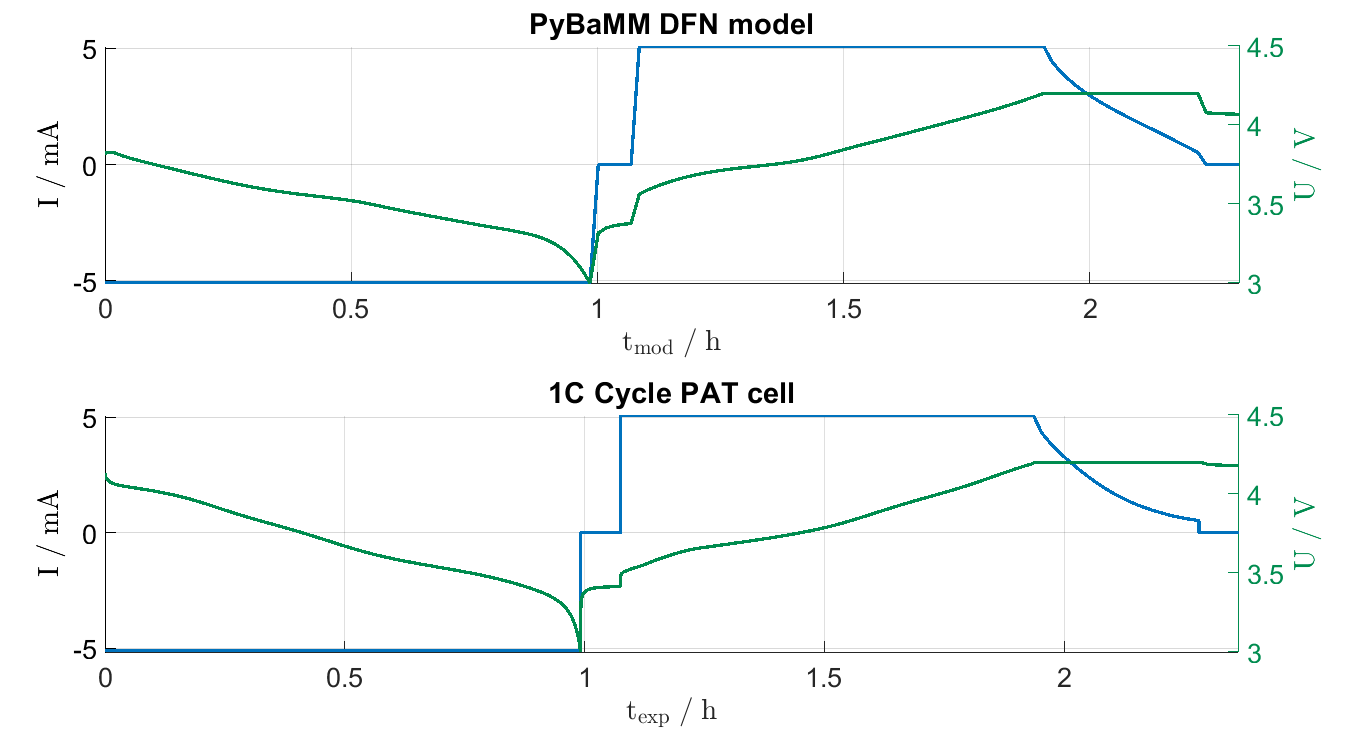
Die Kapazität bestimmt sich aus den übertragenen Lithium-Ionen in dem gegebenen Spannungsbereich. Dies war nach Implementierung der maximalen Konzentrationen und OCV Kurven der Materialien, konnten die gleichen Kapazitätsgrenzen erreicht werden.

Was jedoch noch am stärken auffällt ist, dass die Spannungen bei den hohen und niedrigen SOCs nicht stimmen, dies liegt daran, dass die Grenzen noch verkehrt liegen. Die Grenzen bestimmten sich intern bei PyBaMM nach:
* pybamm.lithium_ion.electrode_soh.ElectrodeSOHSolver (class)

    Definition der physikalisch minimalen und maximalen stöchiometrischen Grenzen bei funktionsdefinierten OCP Kurven für die negative und positive Elektrode auf 1e-6 und 1-1e-6.

    * pybamm.lithium_ion.electrode_soh.get_min_max_stoichiometries

        Als Inputs wird die gesamte in der Zelle befindliche Ladungsmenge und die Ladungsmenge in den jeweiligen Elektroden an einen im folgenden beschriebenen Lösungsalgorithmus übergeben. Als Ausgabe von dieser Funktion werden die maximalen und minimalen stöchiometrischen Grenzen der Materailien als dict übergeben: ["x_0", "x_100", "y_100", "y_0"] (Grenzen Negativ - x, Grenzen Positiv - y)

        * pybamm.lithium_ion.electrode_soh.solve

            Druchlaufen von einem vollständigen und gesplitteten Solveransatz zur Berechnung der minimalen und maximalen Grenzen in Form des vollständigen Modells. Falls keine Lösung des Modells möglich sein sollte, wird die Feasibility einer Lösung untersucht. Zuvor müssen jedoch Anfangswerte für die zu berechnenden Stöchiometrischen Grenzen der Elektroden gegeben werden.

            * pybamm.lithium_ion.electrode_soh._set_up_solve

                Die Startabschätzung erfolgt durch entweder zuvor gelaufende Simulationen oder werden anhand der _get_lims-Funktion.
                // In der Regel wird Q_Li ("cycable lihtium inventory") genutzt. Die Rolle von Q ("capacity") ist noch nicht ganz verstanden.
                **_get_lims**: (inputs=Q_n, Q_p, Q_Li oder Q) 
                1. Plausibilitätstest, ob Q_Li innerhalb der Materialgrenzen liegt
                2. Berechnung der verbleibenen Lithiummenge bei in der positiven Elektrode bei voller oder leerer negativen Elektrode -  vice versa für die negative Elektrode

                Die Grenzen werden nachfolgend allerdings auf 0.2 und 0.8 als Startwerte für den Solver eingeschränkt. Dies basiert nicht gut kommentiert augenscheinlich auf Erfahrungswerten (Z. 279f)


